### MOTIF-BASED EXPLAINER

This notebook represents the analysis of the previously built datasets to explain changes in inclusion levels of Knockdown responsive exons just based on motif ocurrences. 
Each RBP represents a dataset. Ideally, the motifs that would explain given dPSI values (or exon strength) would highlight the RBPs that were knockdown in the given experiment. 

In [92]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
from explainer.datasets.global_explain import GlobalDataset
from gtfhandle.utils import file_to_bed_df

Let's import the spliceAI predictions for all the union of the different exons present in all the datasets

In [93]:
# CODE TO LOAD PROCESSED DATASETS
all_datasets = {#'occurrences_alone': pd.read_csv('occurrences_alone/RBFOX2.tsv.gz', sep="\t")#,
               'occurrences_based_on_location': pd.read_csv('occurrences_based_on_location/PTBP1.tsv.gz', sep="\t"),
               #'occurrences_based_on_location_and_distances': pd.read_csv('occurrences_based_on_location_and_distances/PTBP1.tsv.gz', sep="\t")
               }

In [164]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

def plot_feature_distances(x: pd.DataFrame):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    corr = spearmanr(x).correlation
    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(dist_linkage, labels=x.columns if len(list(x)) < 100 else None, ax=ax1, leaf_rotation=90)
    dendro_idx = np.arange(0, len(dendro["ivl"]))

    ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    if len(list(x)) < 100:
        ax2.set_xticks(dendro_idx)
        ax2.set_yticks(dendro_idx)
        ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
        ax2.set_yticklabels(dendro["ivl"])
        fig.tight_layout()
        plt.show()

In [165]:
#Feature selection class to eliminate multicollinearity
class MultiCollinearityEliminator():
    
    #Class Constructor
    def __init__(self, df, target, threshold):
        self.df = df
        self.target = target
        self.threshold = threshold
        self.correlation_pais = defaultdict(list)

    #Method to create and return the feature correlation matrix dataframe
    def createCorrMatrix(self, include_target = False):
        #Checking we should include the target in the correlation matrix

        if (include_target == False):
            df_temp = self.df.drop([self.target], axis =1)
            
            #Setting method to Pearson to prevent issues in case the default method for df.corr() gets changed
            #Setting min_period to 30 for the sample size to be statistically significant (normal) according to 
            #central limit theorem
            corrMatrix = df_temp.corr(method='spearman', min_periods=30).abs()
        #Target is included for creating the series of feature to target correlation - Please refer the notes under the 
        #print statement to understand why we create the series of feature to target correlation
        elif (include_target == True):
            corrMatrix = self.df.corr(method='spearman', min_periods=30).abs()
    
        return corrMatrix

    #Method to create and return the feature to target correlation matrix dataframe
    def createCorrMatrixWithTarget(self):
        #After obtaining the list of correlated features, this method will help to view which variables 
        #(in the list of correlated features) are least correlated with the target
        #This way, out the list of correlated features, we can ensure to elimate the feature that is 
        #least correlated with the target
        #This not only helps to sustain the predictive power of the model but also helps in reducing model complexity
        
        #Obtaining the correlation matrix of the dataframe (along with the target)
        corrMatrix = self.createCorrMatrix(include_target = True)                           
        #Creating the required dataframe, then dropping the target row 
        #and sorting by the value of correlation with target (in asceding order)

        corrWithTarget = pd.DataFrame(corrMatrix.loc[:,self.target]).drop([self.target], axis = 0).sort_values(by = self.target)         
          
        return corrWithTarget

    #Method to create and return the list of correlated features
    def createCorrelatedFeaturesList(self):
        #Obtaining the correlation matrix of the dataframe (without the target)
        corrMatrix = self.createCorrMatrix(include_target = False)                          
        colCorr = []
        #Iterating through the columns of the correlation matrix dataframe
        for column in corrMatrix.columns:
            #Iterating through the values (row wise) of the correlation matrix dataframe
  
            for idx, row in corrMatrix.iterrows():                                        
                if(row[column]>self.threshold) and (row[column]<1):
                    self.correlation_pais[column].append(idx)
                    #Adding the features that are not already in the list of correlated features
                    if (idx not in colCorr):
                        colCorr.append(idx)
                    if (column not in colCorr):
                        colCorr.append(column)
        #print('Correlated features: {}'.format(colCorr), '\n')
        return colCorr

    #Method to eliminate the least important features from the list of correlated features
    def deleteFeatures(self, colCorr):
        #Obtaining the feature to target correlation matrix dataframe
        corrWithTarget = self.createCorrMatrixWithTarget()                                  
        for idx, row in corrWithTarget.iterrows():

            if (idx in colCorr):
                self.df = self.df.drop(idx, axis =1)
                break
            
        return self.df

    #Method to run automatically eliminate multicollinearity
    def autoEliminateMulticollinearity(self):
        #Obtaining the list of correlated features
        colCorr = self.createCorrelatedFeaturesList()                                       
        while colCorr != []:
            #Obtaining the dataframe after deleting the feature (from the list of correlated features) 
            #that is least correlated with the taregt
            self.df = self.deleteFeatures(colCorr)
            #Obtaining the list of correlated features
            colCorr = self.createCorrelatedFeaturesList()                                     
        return self.df, self.correlation_pais

In [166]:
data=all_datasets['occurrences_based_on_location']
data = data.drop(['seq_id', 'target_coordinates', 'average_cassette_strength', 'RBP'], axis=1)
#data = data.iloc[:, :150]


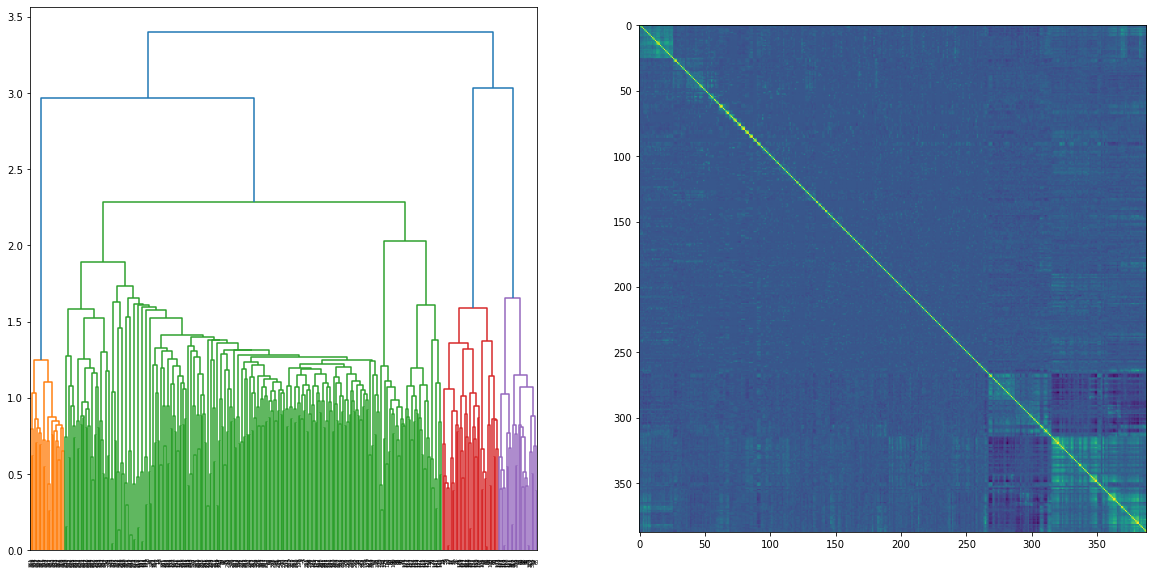

In [167]:
data = data.loc[:, (data != 0).any(axis=0)]
data['exon_group'] = data.exon_group.replace({'KD': 1, 'CTRL': 0})
x = data.drop('exon_group', axis=1)
y = data.exon_group
plot_feature_distances(x)

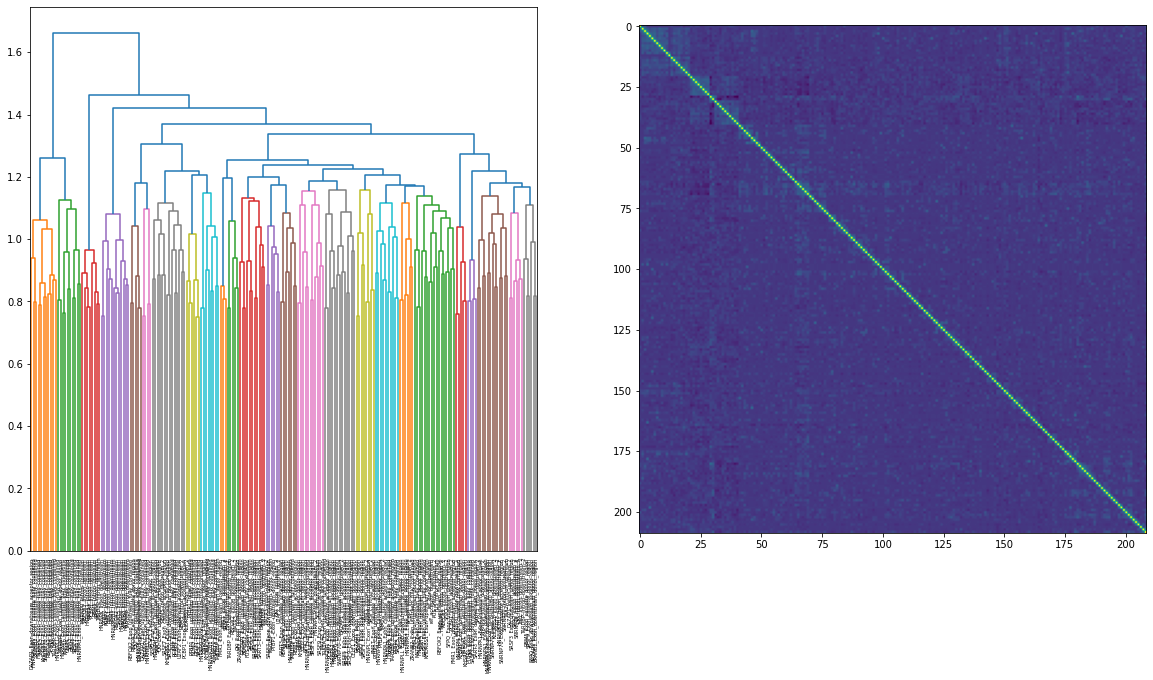

In [161]:
colinearity = MultiCollinearityEliminator(df=data, target='exon_group', threshold=0.25)
data_feat_select, correlated_pairs = colinearity.autoEliminateMulticollinearity()

x = data_feat_select.drop('exon_group', axis=1)
y = data_feat_select.exon_group
plot_feature_distances(x)

In [163]:
x.shape


(1298, 209)

### Plot classification accuracies for the exon group prediction task  

In [117]:
#data = all_datasets['occurrences_alone'].drop(columns=['seq_id', 'target_coordinates', 'RBP'])
data = all_datasets['occurrences_based_on_location'].drop(columns=['seq_id', 'target_coordinates', 'RBP'])

In [118]:
labels = data.exon_group
data = data.drop('exon_group', axis=1)

In [119]:
 data = data.apply(lambda x: (x - x.mean())/x.std(ddof=0))

In [123]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5, whiten=False)

x = pca.fit_transform(data.dropna(axis=1))
print(pca.mean_)
x = pd.DataFrame(data = x, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

[ 2.40861944e-16 -1.97068864e-16  2.18965404e-17  0.00000000e+00
 -1.64224053e-17 -1.36853377e-17 -6.56896212e-17 -2.73706755e-17
  5.47413510e-18  9.85344318e-17 -8.75861616e-17 -4.37930808e-17
  0.00000000e+00  1.91594728e-17 -5.47413510e-18  3.55818781e-17
 -4.65301483e-17 -1.42327513e-16 -8.21120265e-18  2.18965404e-17
 -1.36853377e-17 -1.09482702e-16  2.18965404e-17 -2.73706755e-18
 -6.29525536e-17 -4.65301483e-17 -1.50538715e-17 -2.18965404e-17
  2.46336079e-17 -6.56896212e-17  5.47413510e-17 -1.20430972e-16
 -2.18965404e-17  1.20430972e-16  9.57973642e-18 -8.21120265e-18
 -2.46336079e-17  3.83189457e-17  0.00000000e+00  1.64224053e-17
 -2.18965404e-17  2.18965404e-17 -5.47413510e-18 -3.83189457e-17
  0.00000000e+00  7.66378914e-17  6.56896212e-17 -2.73706755e-17
  2.05280066e-17 -1.64224053e-17  1.50538715e-17 -2.53178748e-17
  1.47801648e-16  8.21120265e-18 -5.47413510e-18  6.56896212e-17
  2.73706755e-17  1.42327513e-16 -7.39008238e-17  1.09482702e-17
 -9.30602967e-17 -6.56896

In [124]:
pca.explained_variance_ratio_

array([0.03590253, 0.01639989, 0.01524991, 0.0134091 , 0.01030816])

<Figure size 432x288 with 0 Axes>

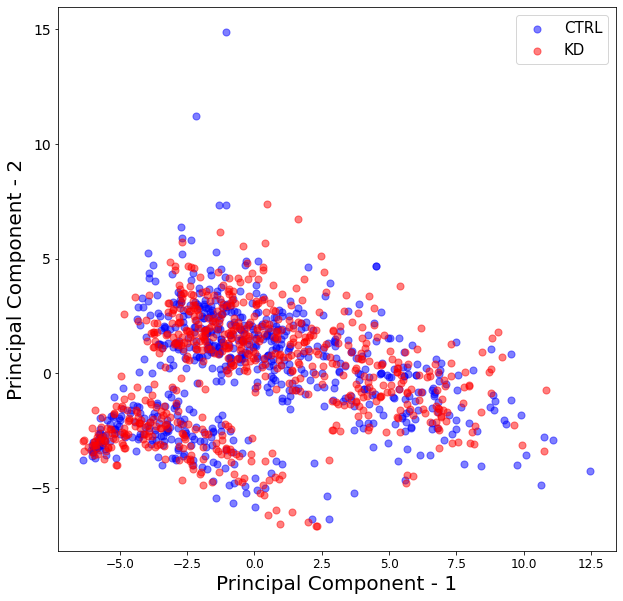

In [127]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
targets = labels.unique()
colors = ['b', 'r']
for target, color in zip(targets, colors):
    indicesToKeep = labels == target

    plt.scatter(x.loc[indicesToKeep, 'PC1']
               , x.loc[indicesToKeep, 'PC2'], alpha=0.5, c = color, s = 50)

plt.legend(targets,prop={'size': 15})

<Figure size 432x288 with 0 Axes>

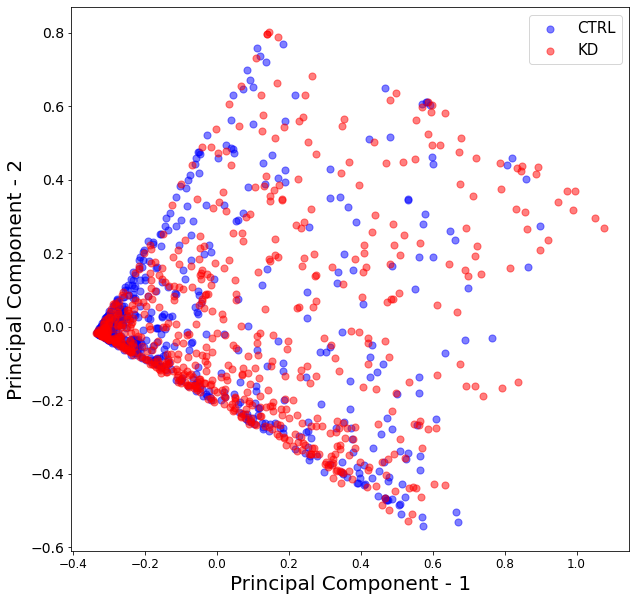

In [73]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
targets = labels.unique()
colors = ['b', 'r']
for target, color in zip(targets, colors):
    indicesToKeep = labels == target

    plt.scatter(x.loc[indicesToKeep, 'PC1']
               , x.loc[indicesToKeep, 'PC2'], alpha=0.5, c = color, s = 50)

plt.legend(targets,prop={'size': 15})